<a href="https://colab.research.google.com/github/Yangxin666/Graph_Autoencoder_Based_Imputation_Summary/blob/main/STGCN_Autoencoders_03_31_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# STCGN Autoencoder (STGCN-AE) for PV Data Imputation
An Application of [Spatio-Temporal Graph Neural Networks](https://arxiv.org/pdf/1709.04875.pdf) for imputation

*Structure of our proposed Spatiotemporal Graph Convolutional Neural Networks-based Denosing Autoencoder*

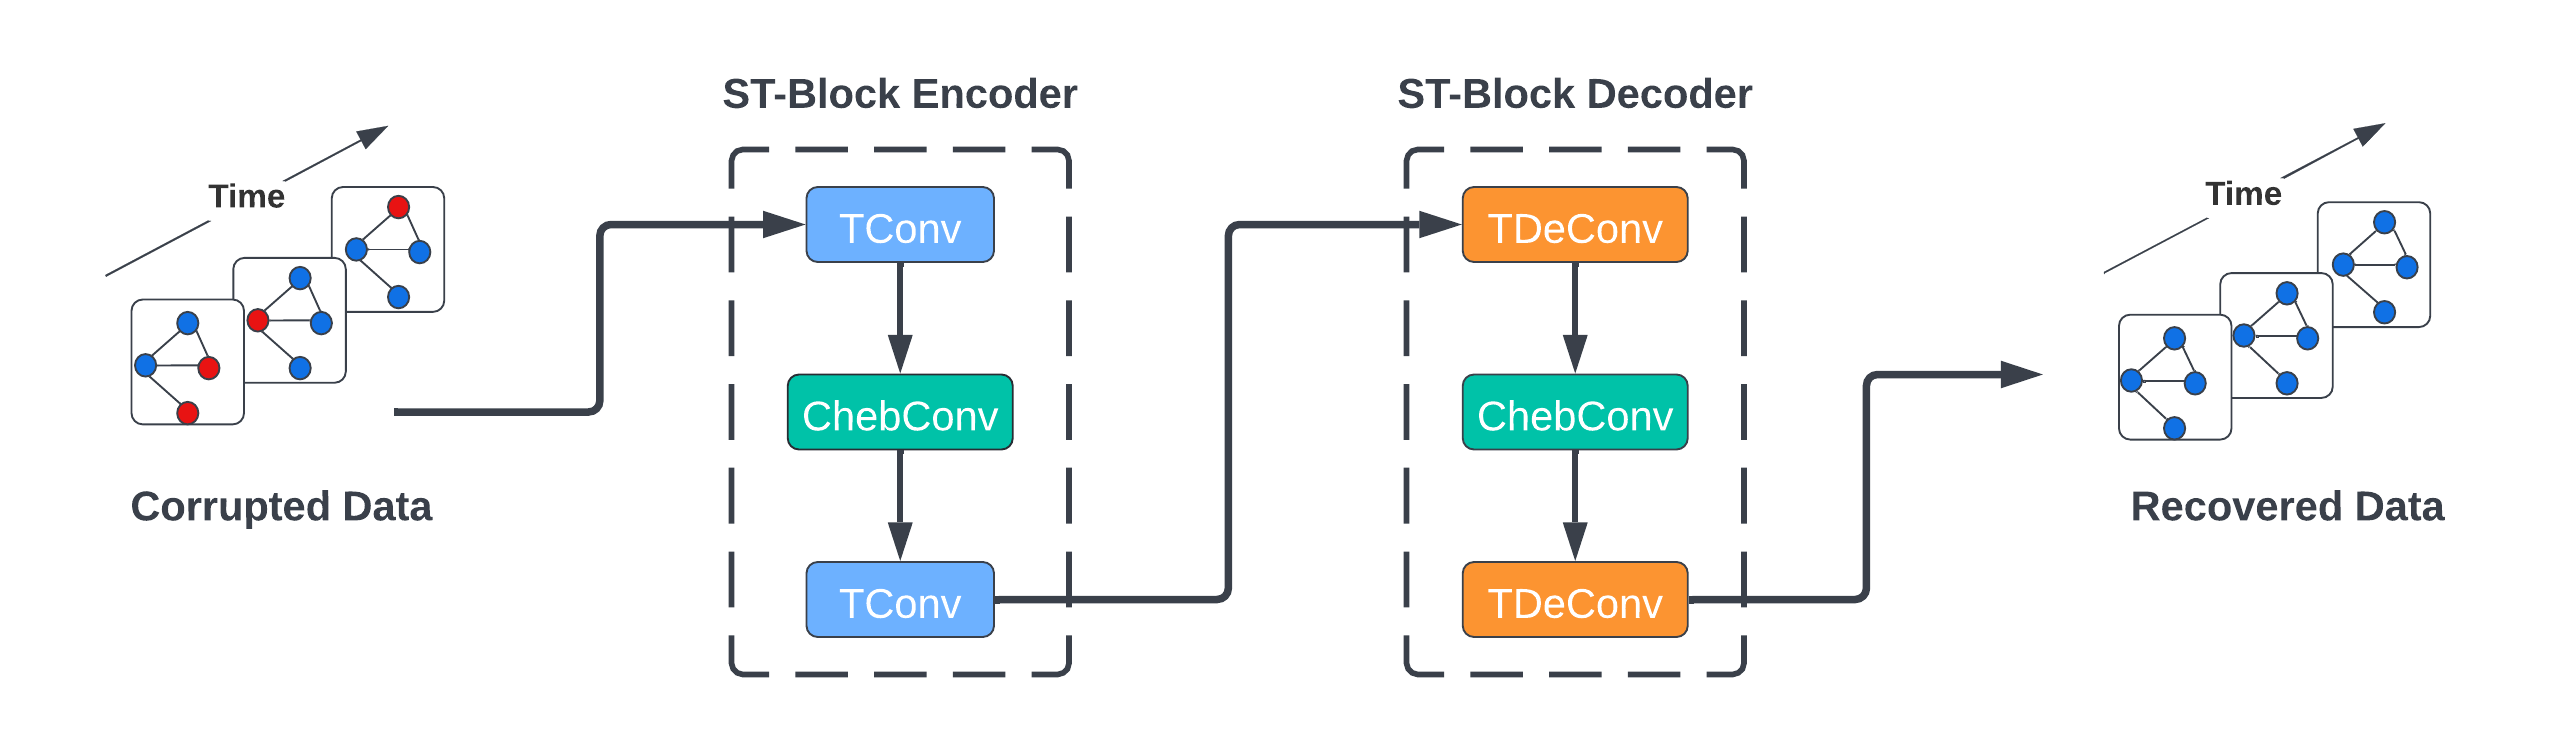

Input: [batch_size, window_size, #nodes, input_channel]

Output: same shape as the above, but corrupted parts are recovered

Training: 240 days 

Validation: 60 days

Testing: 60 days


*   Corrupted data X' are generated from fully observed data X using MCAR/Block Missing Mask Generators
*   In the model training, recovered data X'' will be compared with originally fully observed data X to calculate the reconstruction error in the training phase
*   In the model testing, the imputation accuracy is only measured on masked parts of testing data






### Set Up

In [7]:
# Note that this installation can take a while! Be patient!
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.10.0+${CUDA}.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.10.0+${CUDA}.html
!pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-1.10.0+${CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.10.0+${CUDA}.html
!pip install torch-geometric
!pip install torch-geometric-temporal

Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+.html
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+.html
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+.html
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+.html


In [4]:
from datetime import datetime
import geopy.distance # to compute distances between stations
import glob
import numpy as np
import os
import pandas as pd
import scipy.sparse as sp
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
#from torch_geometric_temporal.nn import STConv
from tqdm import tqdm

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


<a name="part_2"></a>
## 1. Model Building and Training


1.1: Temporal Conv and Deconv Layers

In [8]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import ChebConv

class TemporalConv(nn.Module):

    """
    Args:
        in_channels (int): Number of input features.
        out_channels (int): Number of output features.
        kernel_size (int): Convolutional kernel size.
    """

    def __init__(self, in_channels: int, out_channels: int, kernel_size, stride: int, padding: int):
        super(TemporalConv, self).__init__()
        self.conv_1 = nn.Conv2d(in_channels, out_channels, (1, kernel_size), (1, stride), (0,padding))
        self.conv_2 = nn.Conv2d(in_channels, out_channels, (1, kernel_size), (1, stride), (0,padding))
        self.conv_3 = nn.Conv2d(in_channels, out_channels, (1, kernel_size), (1, stride), (0,padding))

    def forward(self, X: torch.FloatTensor) -> torch.FloatTensor:
        """Forward pass through temporal convolution block.

        Arg types:
            * **X** (torch.FloatTensor) -  Input data of shape
                (batch_size, input_time_steps, num_nodes, in_channels).

        Return types:
            * **H** (torch.FloatTensor) - Output data of shape
                (batch_size, in_channels, num_nodes, input_time_steps).
        """
        X = X.permute(0, 3, 2, 1)
        P = self.conv_1(X)
        Q = torch.sigmoid(self.conv_2(X))
        PQ = P * Q
        H = F.relu(PQ + self.conv_3(X))
        H = H.permute(0, 3, 2, 1)
        return H

class TemporalDeConv1(nn.Module):

    """
    Args:
        in_channels (int): Number of input features.
        out_channels (int): Number of output features.
        kernel_size (int): Convolutional kernel size.
    """

    def __init__(self, in_channels: int, out_channels: int, kernel_size, stride: int, padding: int):
        super(TemporalDeConv1, self).__init__()
        self.conv_1 = nn.ConvTranspose2d(in_channels, out_channels, (1, kernel_size), (1, stride), (0,padding))
        self.conv_2 = nn.ConvTranspose2d(in_channels, out_channels, (1, kernel_size),(1, stride), (0,padding))
        self.conv_3 = nn.ConvTranspose2d(in_channels, out_channels, (1, kernel_size),(1, stride), (0,padding))

    def forward(self, X: torch.FloatTensor) -> torch.FloatTensor:
        """Forward pass through temporal convolution block.

        Arg types:
            * **X** (torch.FloatTensor) -  Input data of shape
                (batch_size, input_time_steps, num_nodes, in_channels).

        Return types:
            * **H** (torch.FloatTensor) - Output data of shape
                (batch_size, in_channels, num_nodes, input_time_steps).
        """
        X = X.permute(0, 3, 2, 1)
        P = self.conv_1(X)
        Q = torch.sigmoid(self.conv_2(X))
        PQ = P * Q
        H = F.relu(PQ + self.conv_3(X))
        H = H.permute(0, 3, 2, 1)
        return H

class TemporalDeConv2(nn.Module):

    """
    Args:
        in_channels (int): Number of input features.
        out_channels (int): Number of output features.
        kernel_size (int): Convolutional kernel size.
    """

    def __init__(self, in_channels: int, out_channels: int, kernel_size, stride: int):
        super(TemporalDeConv2, self).__init__()
        self.conv_1 = nn.ConvTranspose2d(in_channels, out_channels, (1, kernel_size),(1, stride))
        self.conv_2 = nn.ConvTranspose2d(in_channels, out_channels, (1, kernel_size),(1, stride))
        self.conv_3 = nn.ConvTranspose2d(in_channels, out_channels, (1, kernel_size),(1, stride))

    def forward(self, X: torch.FloatTensor) -> torch.FloatTensor:
        """Forward pass through temporal convolution block.

        Arg types:
            * **X** (torch.FloatTensor) -  Input data of shape
                (batch_size, input_time_steps, num_nodes, in_channels).

        Return types:
            * **H** (torch.FloatTensor) - Output data of shape
                (batch_size, in_channels, num_nodes, input_time_steps).
        """
        X = X.permute(0, 3, 2, 1)
        P = self.conv_1(X)
        Q = torch.sigmoid(self.conv_2(X))
        PQ = P * Q
        H = F.relu(PQ + self.conv_3(X))
        H = H.permute(0, 3, 2, 1)
        return H

1.2: ST-Block as Encoder & Decode

In [9]:
class STConvEncoder(nn.Module):

    def __init__(
        self,
        num_nodes: int,
        in_channels: int,
        hidden_channels: int,
        out_channels: int,
        kernel_size: int,
        stride: int,
        padding: int,
        K: int,
        normalization: str = "sym",
        bias: bool = True,
    ):
        super(STConvEncoder, self).__init__()
        self.num_nodes = num_nodes
        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.K = K
        self.normalization = normalization
        self.bias = bias

        self._temporal_conv1 = TemporalConv(
            in_channels=in_channels,
            out_channels=hidden_channels,
            kernel_size=kernel_size, stride = stride, padding = padding,
        )

        self._graph_conv = ChebConv(
            in_channels=hidden_channels,
            out_channels=hidden_channels,
            K=K,
            normalization=normalization,
            bias=bias,
        )

        self._temporal_conv2 = TemporalConv(
            in_channels=hidden_channels,
            out_channels=out_channels,
            kernel_size=kernel_size, stride = stride, padding = padding,
        )

        self._batch_norm = nn.BatchNorm2d(num_nodes)

    def forward(self, X: torch.FloatTensor, edge_index: torch.LongTensor, edge_weight: torch.FloatTensor = None,) -> torch.FloatTensor:

        r"""Forward pass. If edge weights are not present the forward pass
        defaults to an unweighted graph.

        Arg types:
            * **X** (PyTorch FloatTensor) - Sequence of node features of shape (Batch size X Input time steps X Num nodes X In channels).
            * **edge_index** (PyTorch LongTensor) - Graph edge indices.
            * **edge_weight** (PyTorch LongTensor, optional)- Edge weight vector.

        Return types:
            * **T** (PyTorch FloatTensor) - Sequence of node features.
        """
        #print(X.shape)
        T_0 = self._temporal_conv1(X)
        #print(T_0.shape)
        T = torch.zeros_like(T_0).to(T_0.device)
        for b in range(T_0.size(0)):
            for t in range(T_0.size(1)):
                T[b][t] = self._graph_conv(T_0[b][t], edge_index, edge_weight)

        T = F.relu(T)
        #print(T.shape)
        T = self._temporal_conv2(T)
        #print(T.shape)
        # T = T.permute(0, 2, 1, 3)
        # #print(T.shape)
        # T = self._batch_norm(T)
        # T = T.permute(0, 2, 1, 3)
        #print(T.shape)

        return T

In [10]:
class STConvDecoder(nn.Module):

    def __init__(
        self,
        num_nodes: int,
        in_channels: int,
        hidden_channels: int,
        out_channels: int,
        kernel_size: int,
        kernel_size_de: int,
        stride: int,
        padding: int,
        K: int,
        normalization: str = "sym",
        bias: bool = True,
    ):
        super(STConvDecoder, self).__init__()
        self.num_nodes = num_nodes
        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.K = K
        self.normalization = normalization
        self.bias = bias

        self._temporal_conv1 = TemporalDeConv1(
            in_channels=in_channels,
            out_channels=hidden_channels,
            kernel_size=kernel_size, stride = stride, padding = padding,
        )

        self._graph_conv = ChebConv(
            in_channels=hidden_channels,
            out_channels=hidden_channels,
            K=K,
            normalization=normalization,
            bias=bias,
        )

        self._temporal_conv2 = TemporalDeConv2(
            in_channels=hidden_channels,
            out_channels=out_channels,
            kernel_size=kernel_size_de, stride = stride,
        )

        self._batch_norm = nn.BatchNorm2d(num_nodes)

    def forward(self, X: torch.FloatTensor, edge_index: torch.LongTensor, edge_weight: torch.FloatTensor = None,) -> torch.FloatTensor:

        r"""Forward pass. If edge weights are not present the forward pass
        defaults to an unweighted graph.

        Arg types:
            * **X** (PyTorch FloatTensor) - Sequence of node features of shape (Batch size X Input time steps X Num nodes X In channels).
            * **edge_index** (PyTorch LongTensor) - Graph edge indices.
            * **edge_weight** (PyTorch LongTensor, optional)- Edge weight vector.

        Return types:
            * **T** (PyTorch FloatTensor) - Sequence of node features.
        """
        T_0 = self._temporal_conv1(X)
        T = torch.zeros_like(T_0).to(T_0.device)
        for b in range(T_0.size(0)):
            for t in range(T_0.size(1)):
                T[b][t] = self._graph_conv(T_0[b][t], edge_index, edge_weight)

        T = F.relu(T)
        T = self._temporal_conv2(T)
        # T = T.permute(0, 2, 1, 3)
        # T = self._batch_norm(T)
        # T = T.permute(0, 2, 1, 3)
        return T

1.3: STGCN Denoising Autoencoder

In [11]:
# final model
# a specified number of STConv blocks, followed by an output layer
class STConvAE(torch.nn.Module):
    def __init__(self, device, num_nodes, channel_size_list, num_layers, 
                 kernel_size, K, window_size, kernel_size_de, stride, padding,\
                 normalization = 'sym', bias = True):
    # num_nodes = number of nodes in the input graph
    # channel_size_list =  2d array representing feature dimensions throughout the model
    # num_layers = number of STConv blocks
    # kernel_size = length of the temporal kernel
    # K = size of the chebyshev filter for the spatial convolution
    # window_size = number of historical time steps to consider

        super(STConvAE, self).__init__()
        self.layers = nn.ModuleList([])
        # add STConv blocks
        for l in range(num_layers):
            input_size, hidden_size, output_size = channel_size_list[l][0], channel_size_list[l][1], channel_size_list[l][2]
            if l==0:
              self.layers.append(STConvEncoder(num_nodes, input_size, hidden_size, output_size, kernel_size, stride, padding, K, normalization, bias))
            if l==1:
              self.layers.append(STConvDecoder(num_nodes, input_size, hidden_size, output_size, kernel_size, kernel_size_de, stride, padding, K, normalization, bias))
        

        # # add output layer
        # self.layers.append(OutputLayer(channel_size_list[-1][-1], \
        #                                window_size - 2 * num_layers * (kernel_size - 1), \
        #                                num_nodes))
        # CUDA if available
        for layer in self.layers:
            layer = layer.to(device)

    def forward(self, x, edge_index, edge_weight ):
        #print(x.shape)
        for layer in self.layers:
          x = layer(x, edge_index, edge_weight)
          #print(x.shape)
        # out_layer = self.layers[-1]
        # x = x.permute(0, 3, 1, 2)
        # x = out_layer(x)
        # print(x.shape)
        return x

### 2. Model Training



#2.1: Define Parameters

In [12]:
# model parameters
num_nodes = 98
#channels = np.array([[1, 1, 1], [1, 1, 1]]) # sequence of channel sizes
channels = np.array([[1, 2, 2], [2, 2, 1]])
kernel_size = 4 # size of temporal kernel
kernel_size_de = 2 # size of temporal deconv2
stride = 2
padding = 1
K = 3 # chebyshev filter size

# training parameters
learning_rate = 0.001
batch_size = 2
num_epochs = 50 # note that we trained for 7 epochs using Google Cloud
num_layers = 2 # number of STConv blocks
n_his = 288 # window size
train_prop = 2/3 # Our actual training set proportion was 0.7
val_prop = 1/6 # Our actual training set proportion was 0.2
test_prop = 1/6 # Our actual training set proportion was 0.1

# model save path
model_save_path = os.path.join(
    'gdrive', 'MyDrive', 'STGCN', 'best_model.pt')

2.2: Data Preparation

In [13]:
def data_transform(data, corrupted_data, window, device):
    # data = slice of V matrix
    # n_his = number of historical speed observations to consider
    # n_pred = number of time steps in the future to predict

    num_nodes = data.shape[1]
    num_obs = int(len(data)/window)
    x = np.zeros([num_obs, window, num_nodes, 1])
    y = np.zeros([num_obs, window, num_nodes, 1])
    
    obs_idx = 0
    for i in range(num_obs):
        head = i*window
        tail = (i+1)*window
        y[obs_idx, :, :, :] = data[head: tail].reshape(n_his, num_nodes, 1)
        x[obs_idx, :, :, :] = corrupted_data[head: tail].reshape(n_his, num_nodes, 1)
        #x[obs_idx, :, :, :] = data[head: tail].reshape(n_his, num_nodes, 1)
        obs_idx += 1

    return torch.Tensor(x).to(device), torch.Tensor(y).to(device)

Now let's go ahead and convert our processed data into a form we can use to train our model.

In [14]:
W = pd.read_csv('gdrive/My Drive/STGCN/W_98.csv')
V = pd.read_csv('gdrive/My Drive/STGCN/norm_power.csv')
#V = V.iloc[:,:103680]
V = V.T.interpolate(method ='linear', limit_direction ='forward')
V

,0,1,2,3,4,5,6,7,8,9,...,88,89,90,91,92,93,94,95,96,97
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103675,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103676,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103677,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
W

,0,1,2,3,4,5,6,7,8,9,...,88,89,90,91,92,93,94,95,96,97
0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
94,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
95,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
V.iloc[100:200,]

,0,1,2,3,4,5,6,7,8,9,...,88,89,90,91,92,93,94,95,96,97
100,36.819292,16.243614,37.344073,37.187577,38.068182,37.445195,36.966776,18.336111,19.659540,41.318681,...,38.611997,0.000000,15.749811,7.114815,7.069444,41.269841,36.885185,15.512721,19.321665,18.562963
101,38.553114,16.291507,39.970353,38.892122,39.709936,39.036049,38.710008,19.368519,18.482515,42.995523,...,42.146333,0.000000,11.542126,7.072222,7.013889,42.946683,34.897222,15.543185,17.703371,18.314815
102,40.238095,16.647709,40.534392,40.521625,41.454300,40.766959,40.396109,16.070370,15.560725,44.818885,...,43.204490,0.000000,21.380414,6.729630,6.699074,44.607245,39.864815,15.787822,15.110225,15.729630
103,41.974969,19.081258,48.750723,42.229233,43.050110,42.523749,41.969413,18.052778,17.955393,46.186406,...,48.115829,0.000000,22.687300,7.159259,7.119444,46.235246,44.620370,19.166574,17.579668,18.232407
104,43.235653,20.326469,48.418825,43.713244,44.541779,44.049141,43.412340,18.040741,17.977549,47.960928,...,48.156850,0.000000,17.685712,9.025926,8.994444,48.140008,46.279630,18.854547,17.598132,17.957407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,30.953907,0.000000,29.954690,31.299008,31.265315,32.928389,29.781437,29.554630,30.230604,31.762312,...,29.615334,51.092293,52.715148,17.019444,16.816667,32.315832,28.626852,0.000000,29.756102,29.980556
196,29.484127,0.000000,28.113405,29.844095,29.834906,31.500426,28.436658,28.173148,28.728629,30.362230,...,27.675225,49.526791,50.901385,11.117593,11.010185,30.932031,26.258333,0.000000,28.241202,28.469444
197,27.880037,0.000000,25.986836,28.478008,28.340174,29.857813,26.927810,26.517593,26.970939,28.636549,...,25.729522,52.717095,48.806703,8.296296,8.243519,29.124949,23.483333,0.000000,26.544441,26.821296
198,26.619353,0.000000,22.782532,27.085886,26.997060,28.492266,25.574241,24.815741,25.301872,27.122507,...,23.357760,32.235110,49.289152,8.617593,8.567593,27.757428,19.405556,0.000000,24.911377,25.175000


In [ ]:
min(np.min(V))

-0.4012962400702

# 2.2: Missing Value Injection

#MCAR

In [ ]:
mask = torch.FloatTensor(103680, 8).uniform_() > 0.4
pd.DataFrame(mask.numpy()).to_csv('gdrive/My Drive/STGCN/40%MCAR_8.csv',index=False)

#Block Missing

In [ ]:
import random
np.random.randint(0,98,10)

array([ 0, 53, 33, 22,  5, 52,  0, 23, 57, 78])

[0, 288] a day interval
inject 98 interval as a mask randomly
12 hours
6AM - 2PM 

1. Variance of MAE/RMSE for baseline vs. GCN-AE
2. GCN-AE robustness compared with other methods

Construct edges based on inbound (adaptive)

In [ ]:
import random
#nb_interval=0
missing_percent = 0.25
#length=int(3456*0.2)
length=72
limit_low=0
limit_high=69120
mask = torch.full((103680,98), True)
num = int(missing_percent*3456/length)
for i in range(360):
  for j in range(98):
    number = random.randint(288*i+1,288*(i+1)-length-1)
    mask[number:number+length, j] = False

pd.DataFrame(mask.numpy()).to_csv('gdrive/My Drive/STGCN/33%BM_360days_98_2.csv',index=False)
# Plants = np.random.randint(0,98,7)
# print(Plants)
# for i in Plants:
#   for j in range(240):
#     start = 288*j+48
#     end = 288*j+240
#     mask[start:end, i] = False


#pd.DataFrame(mask.numpy()).to_csv('gdrive/My Drive/STGCN/Plants_corrupted.csv',index=False)

In [ ]:
mask = pd.read_csv('gdrive/My Drive/STGCN/33%BM_360days_98_2.csv')
mask = torch.tensor(mask.values)
V_corrupted = pd.read_csv('gdrive/My Drive/STGCN/norm_power.csv')
V_corrupted = V_corrupted.iloc[:,:103680]
V_corrupted = V_corrupted.T.interpolate(method ='linear', limit_direction ='forward')
V_corrupted[mask.numpy()==False] = -1
V_corrupted

,0,1,2,3,4,5,6,7,8,9,...,88,89,90,91,92,93,94,95,96,97
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103675,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103676,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103677,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
wspa_tensor = torch.tensor(V.values)
length = V.shape[0]
train_x = wspa_tensor[0:int(train_prop*length),:].to(torch.float32)
validation_x = wspa_tensor[int(train_prop*length):int((train_prop+val_prop)*length)+1,:].to(torch.float32)
test_x = wspa_tensor[int((train_prop+val_prop)*length)+1:length,:].to(torch.float32)

wspa_corrupted_tensor = torch.tensor(V_corrupted.values)
length = V_corrupted.shape[0]
corrupted_train_x = wspa_corrupted_tensor[0:int(train_prop*length),:].to(torch.float32)
corrupted_validation_x = wspa_corrupted_tensor[int(train_prop*length):int((train_prop+val_prop)*length)+1,:].to(torch.float32)
corrupted_test_x = wspa_corrupted_tensor[int((train_prop+val_prop)*length)+1:length,:].to(torch.float32)

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() \
else torch.device("cpu")

x_train, y_train = data_transform(train_x.numpy(), corrupted_train_x.numpy(), n_his, device)
x_val, y_val = data_transform(validation_x.numpy(), corrupted_validation_x.numpy(), n_his, device)
x_test, y_test = data_transform(test_x.numpy(), corrupted_test_x.numpy(), n_his, device)

# create torch data iterables for training
train_data = torch.utils.data.TensorDataset(x_train, y_train)
train_iter = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
val_data = torch.utils.data.TensorDataset(x_val, y_val)
val_iter = torch.utils.data.DataLoader(val_data, batch_size)
test_data = torch.utils.data.TensorDataset(x_test, y_test)
test_iter = torch.utils.data.DataLoader(test_data, batch_size)

# format graph for pyg layer inputs
G = sp.coo_matrix(W)
edge_index = torch.tensor(np.array([G.row, G.col]), dtype=torch.int64).to(device)
edge_weight = torch.tensor(G.data).float().to(device)

#2.3: Model Training

First let's initialize our model and define our loss and optimizer. Our loss function will be MSE loss, and we'll use an Adam optimizer.

In [ ]:
model = STConvAE(device, num_nodes, channels, num_layers, kernel_size, K, n_his, kernel_size_de, stride, padding, normalization = 'sym', bias = True).to(device)
# define loss function
loss = nn.MSELoss()
# define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = 0.02) 

In [ ]:
min_valid_loss = np.inf

for epoch in tqdm(range(1, num_epochs + 1), desc = 'Epoch', position = 0):
  train_loss, n = 0.0, 0
  model.train()

  for x, y in tqdm(train_iter, desc = 'Batch', position = 0):
    # get model predictions and compute loss
    y_pred = model(x.to(device), edge_index, edge_weight)
    #pred = y_pred[x.cpu().numpy()==-40]
    #ground_truth = y[x.cpu().numpy()==-40]
    #l = loss(y_pred, y)
    #loss = torch.mean((pred-ground_truth)**2)
    loss = torch.mean((y_pred-y)**2)
    # backpropogation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #print("Loss is:"+ str(loss))
    train_loss += loss.item()

  valid_loss = 0.0
  model.eval() 
  for x, y in tqdm(val_iter, desc = 'Batch', position = 0):
    # get model predictions and compute loss
    y_pred = model(x.to(device), edge_index, edge_weight)
    #pred = y_pred[x.cpu().numpy()==-40]
    #ground_truth = y[x.cpu().numpy()==-40]
    #l = loss(y_pred, y)
    #loss = torch.mean((pred-ground_truth)**2)
    #l = loss(y_pred, y)
    loss = torch.mean((y_pred-y)**2)
    valid_loss += loss.item() 

  print(f'Epoch {epoch} \t\t Training Loss: {train_loss/60} \t\t Validation Loss: {valid_loss/15}')
  if min_valid_loss > valid_loss:
    min_valid_loss = valid_loss
    torch.save(model.state_dict(), model_save_path)

Epoch:   2%|▏         | 1/50 [03:09<2:34:33, 189.26s/it]

Epoch 1 		 Training Loss: 577.9313110351562 		 Validation Loss: 1142.827498372396


Epoch:   4%|▍         | 2/50 [06:14<2:29:35, 186.99s/it]

Epoch 2 		 Training Loss: 411.6854473114014 		 Validation Loss: 549.0234761555989


Epoch:   6%|▌         | 3/50 [09:18<2:25:29, 185.74s/it]

Epoch 3 		 Training Loss: 189.6116839726766 		 Validation Loss: 117.48467763264973


Epoch:   8%|▊         | 4/50 [12:25<2:22:38, 186.05s/it]

Epoch 4 		 Training Loss: 49.3063588142395 		 Validation Loss: 80.51998596191406


Epoch:  10%|█         | 5/50 [15:30<2:19:21, 185.81s/it]

Epoch 5 		 Training Loss: 38.27525412241618 		 Validation Loss: 70.78566106160481


Epoch:  12%|█▏        | 6/50 [18:35<2:16:02, 185.51s/it]

Epoch 6 		 Training Loss: 33.85836199124654 		 Validation Loss: 65.76791381835938


Epoch:  14%|█▍        | 7/50 [21:40<2:12:45, 185.25s/it]

Epoch 7 		 Training Loss: 31.3686621427536 		 Validation Loss: 62.86355107625325


Epoch:  16%|█▌        | 8/50 [24:45<2:09:43, 185.32s/it]

Epoch 8 		 Training Loss: 29.82000834941864 		 Validation Loss: 60.45681330362956


Epoch:  18%|█▊        | 9/50 [27:52<2:06:54, 185.71s/it]

Epoch 9 		 Training Loss: 28.531365442276 		 Validation Loss: 58.59823913574219


Epoch:  20%|██        | 10/50 [30:58<2:03:47, 185.70s/it]

Epoch 10 		 Training Loss: 27.49091533025106 		 Validation Loss: 57.045762125651045


Epoch:  22%|██▏       | 11/50 [34:06<2:01:15, 186.56s/it]

Epoch 11 		 Training Loss: 26.60060349305471 		 Validation Loss: 55.36531066894531


Epoch:  24%|██▍       | 12/50 [37:11<1:57:50, 186.07s/it]

Epoch 12 		 Training Loss: 25.725780113538107 		 Validation Loss: 53.83397890726725


Epoch:  26%|██▌       | 13/50 [40:17<1:54:41, 185.98s/it]

Epoch 13 		 Training Loss: 24.936372129122415 		 Validation Loss: 52.436471176147464


Epoch:  28%|██▊       | 14/50 [43:22<1:51:29, 185.83s/it]

Epoch 14 		 Training Loss: 24.141422462463378 		 Validation Loss: 50.8592030843099


Epoch:  30%|███       | 15/50 [46:26<1:48:00, 185.15s/it]

Epoch 15 		 Training Loss: 23.392155345280965 		 Validation Loss: 49.27652282714844


Epoch:  32%|███▏      | 16/50 [49:31<1:44:55, 185.17s/it]

Epoch 16 		 Training Loss: 22.660218119621277 		 Validation Loss: 47.85697848002116


Epoch:  34%|███▍      | 17/50 [52:36<1:41:50, 185.18s/it]

Epoch 17 		 Training Loss: 21.871190655231477 		 Validation Loss: 46.30404841105143


Epoch:  36%|███▌      | 18/50 [55:41<1:38:37, 184.92s/it]

Epoch 18 		 Training Loss: 21.210259501139323 		 Validation Loss: 44.8911195119222


Epoch:  38%|███▊      | 19/50 [58:45<1:35:28, 184.78s/it]

Epoch 19 		 Training Loss: 20.4698113044103 		 Validation Loss: 43.367955271403


Epoch:  40%|████      | 20/50 [1:01:51<1:32:34, 185.14s/it]

Epoch 20 		 Training Loss: 19.733153653144836 		 Validation Loss: 41.93820775349935


Epoch:  42%|████▏     | 21/50 [1:04:56<1:29:29, 185.17s/it]

Epoch 21 		 Training Loss: 19.085969948768614 		 Validation Loss: 40.45511004130046


Epoch:  44%|████▍     | 22/50 [1:08:00<1:26:15, 184.83s/it]

Epoch 22 		 Training Loss: 18.377799050013223 		 Validation Loss: 39.040079498291014


Epoch:  46%|████▌     | 23/50 [1:11:05<1:23:11, 184.86s/it]

Epoch 23 		 Training Loss: 17.749297912915548 		 Validation Loss: 37.76652908325195


Epoch:  48%|████▊     | 24/50 [1:14:10<1:20:04, 184.79s/it]

Epoch 24 		 Training Loss: 17.138553857803345 		 Validation Loss: 36.433067067464194


Epoch:  50%|█████     | 25/50 [1:17:15<1:16:57, 184.72s/it]

Epoch 25 		 Training Loss: 16.579404600461324 		 Validation Loss: 35.26956443786621


Epoch:  52%|█████▏    | 26/50 [1:20:19<1:13:55, 184.80s/it]

Epoch 26 		 Training Loss: 16.101085102558137 		 Validation Loss: 34.2441209157308


Epoch:  54%|█████▍    | 27/50 [1:23:23<1:10:44, 184.55s/it]

Epoch 27 		 Training Loss: 15.603623831272126 		 Validation Loss: 33.256920433044435


Epoch:  56%|█████▌    | 28/50 [1:26:27<1:07:34, 184.31s/it]

Epoch 28 		 Training Loss: 15.17227056423823 		 Validation Loss: 32.30587418874105


Epoch:  58%|█████▊    | 29/50 [1:29:32<1:04:32, 184.40s/it]

Epoch 29 		 Training Loss: 14.773388202985128 		 Validation Loss: 31.583323669433593


Epoch:  60%|██████    | 30/50 [1:32:36<1:01:26, 184.32s/it]

Epoch 30 		 Training Loss: 14.470939071973165 		 Validation Loss: 30.946372159322102


Epoch:  62%|██████▏   | 31/50 [1:35:40<58:21, 184.29s/it]  

Epoch 31 		 Training Loss: 14.184444578488668 		 Validation Loss: 30.285939343770345


Epoch:  64%|██████▍   | 32/50 [1:38:46<55:23, 184.62s/it]

Epoch 32 		 Training Loss: 13.947994736830394 		 Validation Loss: 29.762613932291668


Epoch:  66%|██████▌   | 33/50 [1:41:52<52:26, 185.09s/it]

Epoch 33 		 Training Loss: 13.69244917233785 		 Validation Loss: 29.341113344828287


Epoch:  68%|██████▊   | 34/50 [1:44:57<49:22, 185.13s/it]

Epoch 34 		 Training Loss: 13.499347098668416 		 Validation Loss: 29.03876984914144


Epoch:  70%|███████   | 35/50 [1:48:01<46:13, 184.89s/it]

Epoch 35 		 Training Loss: 13.374140920241674 		 Validation Loss: 28.562604713439942


Epoch:  72%|███████▏  | 36/50 [1:51:06<43:06, 184.72s/it]

Epoch 36 		 Training Loss: 13.219394294420878 		 Validation Loss: 28.235554059346516


Epoch:  74%|███████▍  | 37/50 [1:54:09<39:56, 184.32s/it]

Epoch 37 		 Training Loss: 13.070506997903188 		 Validation Loss: 28.045325152079265


Epoch:  76%|███████▌  | 38/50 [1:57:14<36:54, 184.57s/it]

Epoch 38 		 Training Loss: 12.934880483150483 		 Validation Loss: 27.810232798258465


Epoch:  78%|███████▊  | 39/50 [2:00:19<33:49, 184.51s/it]

Epoch 39 		 Training Loss: 12.853583033879598 		 Validation Loss: 27.504010518391926


Epoch:  80%|████████  | 40/50 [2:03:23<30:44, 184.44s/it]

Epoch 40 		 Training Loss: 12.710051695505777 		 Validation Loss: 27.320757548014324


Epoch:  82%|████████▏ | 41/50 [2:06:28<27:41, 184.60s/it]

Epoch 41 		 Training Loss: 12.638808802763622 		 Validation Loss: 27.082315762837727


Epoch:  84%|████████▍ | 42/50 [2:09:32<24:35, 184.44s/it]

Epoch 42 		 Training Loss: 12.523097598552704 		 Validation Loss: 26.94686075846354


Epoch:  86%|████████▌ | 43/50 [2:12:37<21:31, 184.53s/it]

Epoch 43 		 Training Loss: 12.429157209396362 		 Validation Loss: 26.766443570454914


Epoch:  88%|████████▊ | 44/50 [2:15:40<18:25, 184.25s/it]

Epoch 44 		 Training Loss: 12.304192209243775 		 Validation Loss: 26.47591101328532


Epoch:  90%|█████████ | 45/50 [2:18:45<15:21, 184.31s/it]

Epoch 45 		 Training Loss: 12.170099719365437 		 Validation Loss: 26.10972652435303


Epoch:  92%|█████████▏| 46/50 [2:21:50<12:18, 184.71s/it]

Epoch 46 		 Training Loss: 12.145224970579147 		 Validation Loss: 26.494540659586587


Epoch:  94%|█████████▍| 47/50 [2:24:56<09:14, 184.90s/it]

Epoch 47 		 Training Loss: 11.975055116415025 		 Validation Loss: 25.629615052541098


Epoch:  96%|█████████▌| 48/50 [2:28:00<06:09, 184.88s/it]

Epoch 48 		 Training Loss: 11.727857959270477 		 Validation Loss: 25.427007102966307


Epoch:  98%|█████████▊| 49/50 [2:31:05<03:04, 184.84s/it]

Epoch 49 		 Training Loss: 11.642798113822938 		 Validation Loss: 25.45581080118815


Epoch: 100%|██████████| 50/50 [2:34:09<00:00, 184.99s/it]

Epoch 50 		 Training Loss: 11.494568852583567 		 Validation Loss: 24.93644650777181


#3. Evaluate Model
Now let's see how it performed on the test set.

In [ ]:
# load model with lowest validation lost
best_model = STConvAE(device, num_nodes, channels, num_layers, kernel_size, K, n_his, kernel_size_de, stride, padding, normalization = 'sym', bias = True).to(device)
best_model.load_state_dict(torch.load(model_save_path))

best_model.eval()
cost = 0
missing_count = 0
predicted = []
ground_truth = []

i = 1

for x, y in tqdm(test_iter, desc = 'Batch', position = 0):
    # get model predictions and compute loss
    y_pred = best_model(x.to(device), edge_index, edge_weight)
    if i == 1:
      y_pred_complete = y_pred
    else:
      y_pred_complete = torch.cat((y_pred_complete, y_pred), 0)
    i+=1

print(y_pred_complete.shape)

Batch: 100%|██████████| 15/15 [00:28<00:00,  1.92s/it]

torch.Size([60, 288, 98, 1])


In [ ]:
pred = y_pred_complete[x_test.numpy()==-1]
ground_truth = y_test[x_test.numpy()==-1]
print("Test MSE of STGCN-AE is: "+ str(torch.mean((pred-ground_truth)**2)))
print("Test MAE is of STGCN-AE is: "+ str(torch.mean(abs(pred-ground_truth))))

Test MSE of STGCN-AE is: tensor(68.5026, grad_fn=<MeanBackward0>)
Test MAE is of STGCN-AE is: tensor(3.7300, grad_fn=<MeanBackward0>)


In [ ]:
#Linear Interpolation
corrupted_test_x[corrupted_test_x==-1] = np.nan
test = pd.DataFrame(corrupted_test_x.numpy())
LI_imputed = test.interpolate(method ='linear', limit_direction ='forward')
#LI_imputed = LI_imputed.dropna()
LI_imputed = LI_imputed.fillna(LI_imputed.mean())
LI_imputed = torch.tensor(LI_imputed.values)
LI_pred = LI_imputed[~mask[86400:103680,]]
print("Test MSE of Linear Interpolation is: "+ str(torch.mean((LI_pred.cpu()-ground_truth.cpu())**2)))
print("Test MAE of Linear Interpolation is: "+ str(torch.mean(abs(LI_pred.cpu()-ground_truth.cpu()))))

Test MSE of Linear Interpolation is: tensor(383.1391)
Test MAE of Linear Interpolation is: tensor(15.1330)


In [ ]:
#Mean Imputation
corrupted_test_x[corrupted_test_x==-1] = np.nan
test = pd.DataFrame(corrupted_test_x.numpy())
Mean_imputed = test.fillna(test.mean())
Mean_imputed = torch.tensor(Mean_imputed.values)
Mean_pred = Mean_imputed[~mask[86400:103680,]]
print("Test MSE of Mean Imputation is: "+ str(torch.mean((Mean_pred.cpu()-ground_truth.cpu())**2)))
print("Test MAE of Mean Imputation is: "+ str(torch.mean(abs(Mean_pred.cpu()-ground_truth.cpu()))))

Test MSE of Mean Imputation is: tensor(963.6891)
Test MAE of Mean Imputation is: tensor(24.8381)


In [ ]:
!pip install fancyimpute

     |████████████████████████████████| 154 kB 6.5 MB/s 
  Created wheel for fancyimpute: filename=fancyimpute-0.7.0-py3-none-any.whl size=29899 sha256=d470ce93060081b7a051c30f470a9523e431685f55ca9cfb1df1c13e177a82c0
  Stored in directory: /root/.cache/pip/wheels/e3/04/06/a1a7d89ef4e631ce6268ea2d8cde04f7290651c1ff1025ce68
  Created wheel for knnimpute: filename=knnimpute-0.1.0-py3-none-any.whl size=11353 sha256=6713b4bd7efabf18a41fbd5d927ab15101665a105b758b6c7652f99767cd37c8
  Stored in directory: /root/.cache/pip/wheels/72/21/a8/a045cacd9838abd5643f6bfa852c0796a99d6b1494760494e0
Successfully built fancyimpute knnimpute


In [ ]:
#MICE
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor()
imp = IterativeImputer(estimator = knn, max_iter=1, verbose=-1, initial_strategy = 'median', imputation_order='ascending',random_state=42)
imp.fit(train)
MICE_imputed = imp.transform(test)
MICE_imputed = pd.DataFrame(MICE_imputed)
MICE_imputed = torch.tensor(MICE_imputed.values)
MICE_pred = MICE_imputed[~mask[86400:103680,]]
print("Test MSE of MICE Interpolation is: "+ str(torch.mean((MICE_pred.cpu()-ground_truth.cpu())**2)))
print("Test MAE of MICE Interpolation is: "+ str(torch.mean(abs(MICE_pred.cpu()-ground_truth.cpu()))))

NameError: ignored

In [ ]:
# import the KNNimputer class
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)
imputer.fit(train)
KNN_imputed = imputer.transform(test)
KNN_imputed = pd.DataFrame(KNN_imputed)
KNN_imputed = torch.tensor(KNN_imputed.values)
KNN_pred = KNN_imputed[~mask[86400:103680,]]
print("Test MSE of KNN Interpolation is: "+ str(torch.mean((KNN_pred.cpu()-ground_truth.cpu())**2)))
print("Test MAE of KNN Interpolation is: "+ str(torch.mean(abs(KNN_pred.cpu()-ground_truth.cpu()))))

Test MSE of KNN Interpolation is: tensor(83.4076)
Test MAE of KNN Interpolation is: tensor(4.1545)


## References

California Department of Transportation. Caltrans Performance Measurement System (PeMS). URL: https://pems.dot.ca.gov/ [last accessed December 7, 2021]

Charles R. Harris et al. "Array programming with NumPy". In: Nature 585.7825 (Sept. 2020), pp. 357–362.DOI:10.1038/s41586–020–2649–2. URL: https://doi.org/10.1038/s41586-020-2649-2.

Fey, M., Lenssen, J. Fast Graph Representation Learning with PyTorch Geometric. (2019) arXiv:1903.02428.

The pandas development team.pandas-dev/pandas: Pandas. Version latest. Feb. 2020. DOI: 10.5281/zenodo.3509134. URL: https://doi.org/10.5281/zenodo.3509134.

Adam Paszke et al. "PyTorch: An Imperative Style, High-Performance Deep Learning Library". In: Advances inNeural Information Processing Systems 32. Ed. by H. Wallach et al. Curran Associates, Inc., 2019, pp. 8024–8035. URL:http://papers.neurips.cc/paper/9015- pytorch- an- imperative- style- high-performance-deep-learning-library.pdf.

Rozemberczki, B., Scherer, P., He, Y., Panagopoulos, G., Riedel, A., Astefanoaei, M., Kiss, O., Beres, F., Lopez, G., Collignon, N., and Sarkar, R. PyTorch Geometric Temporal: Spatiotemporal SignalProcessing with Neural Machine Learning Models. In Proceedings of the 30th ACM International Conference on Information and Knowledge Management (2021), p. 4564-4573.

Vivek, S. (2021, November 25). Visualizing real-time traffic patterns using here Traffic Api. Medium. Retrieved December 9, 2021, from https://towardsdatascience.com/visualizing-real-time-traffic-patterns-using-here-traffic-api-5f61528d563.

Yu, B., Yin, H., and Zhu, Z. Spatio-Temporal Graph Convolutional Networks: A Deep Learning Framework for Traffic Forecasting. arXiv e-prints (Sept. 2017), arXiv:1709.04875.

Yu, B., Yin, H., and Zhu, Z. (April 28, 2019). Spatio-Temporal Graph Convolutional Networks: A Deep Learning Framework for Traffic Forecasting [electronic resource: python source code (GitHub repository)]. URL:https://github.com/VeritasYin/STGCN_IJCAI-18